In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
model_metadata = pd.read_csv("../../config/models.csv")
palette = model_metadata.set_index("description")["color"].to_dict()
model_renaming = model_metadata.set_index("name")["description"].to_dict()
model_metadata

,name,description,color
0,CADD,CADD,C0
1,GPN-MSA,GPN-MSA,C1
2,Borzoi,Borzoi,C2
3,Enformer,Enformer,C3
4,GPN,gLM-Promoter,C4
5,NucleotideTransformer,NT,C5
6,HyenaDNA,HyenaDNA,C6
7,Caduceus,Caduceus,C7
8,CADD+GPN-MSA+Borzoi,Ensemble,C8
9,Sei,Sei,C9


In [27]:
dataset_renaming = {
    "complex_traits_matched_9": "Complex traits",
}

subset_renaming = {
    "pleiotropy_yes": "Pleiotropic",
    "pleiotropy_no": "Single trait",
}

In [28]:
datasets = [
    "complex_traits_matched_9",
]

subsets = [
    "pleiotropy_yes",
    "pleiotropy_no",
]

modalities = [
    "Zero-shot",
    "Linear probing",
]

models = [
    "Borzoi",
    "GPN-MSA",
    "CADD",
    "CADD+GPN-MSA+Borzoi",
]

metric = "AUPRC"

def get_model_path(model, modality, dataset, subset):
    if modality == "Linear probing":
        predictor = f"{model}.LogisticRegression.chrom.subset_from_all"
    elif modality == "Zero-shot":
        if model == "CADD":
            predictor = "CADD.plus.RawScore"
        elif model in ["Enformer", "Borzoi"]:
            predictor = f"{model}_L2_L2.plus.all"
        else:
            if "mendelian" in dataset:
                llr_version = "LLR"
                sign = "minus"
            elif "complex" in dataset:
                llr_version = "absLLR"
                sign = "plus"
            predictor = f"{model}_{llr_version}.{sign}.score"
    return f"../../results/dataset/{dataset}/{metric}_by_chrom_weighted_average/{subset}/{predictor}.csv"

In [29]:
rows = []
for dataset in datasets:
    for subset in subsets:
        for modality in modalities:
            for model in models:
                if modality == "Zero-shot" and "+" in model: continue
                model_for_path = model
                if "mendelian" in dataset and model == "CADD+GPN-MSA+Borzoi":
                    model_for_path = "CADD+GPN-MSA_LLR+Borzoi_L2_L2"
                path = get_model_path(
                    model_for_path,
                    modality,
                    dataset,
                    subset
                )
                df = pd.read_csv(path).iloc[0]
                rows.append([
                    dataset_renaming.get(dataset, dataset),
                    subset_renaming.get(subset, subset),
                    modality,
                    model_renaming.get(model, model),
                    df["score"],
                    df["se"],
                ])
df = pd.DataFrame(rows, columns=["dataset", "subset", "modality", "model", "score", "se"])
df

,dataset,subset,modality,model,score,se
0,Complex traits,Pleiotropic,Zero-shot,Borzoi,0.356674,0.023319
1,Complex traits,Pleiotropic,Zero-shot,GPN-MSA,0.301935,0.024214
2,Complex traits,Pleiotropic,Zero-shot,CADD,0.343844,0.023873
3,Complex traits,Pleiotropic,Linear probing,Borzoi,0.428148,0.027770
4,Complex traits,Pleiotropic,Linear probing,GPN-MSA,0.339975,0.024311
5,Complex traits,Pleiotropic,Linear probing,CADD,0.384081,0.023784
6,Complex traits,Pleiotropic,Linear probing,Ensemble,0.495051,0.024317
7,Complex traits,Single trait,Zero-shot,Borzoi,0.209183,0.009855
8,Complex traits,Single trait,Zero-shot,GPN-MSA,0.209837,0.010870
9,Complex traits,Single trait,Zero-shot,CADD,0.233479,0.011676


In [30]:
def best_modality(df):
    res = df.sort_values("score", ascending=False).iloc[0]
    return res[["score", "se"]]

df = df.groupby(["dataset", "subset", "model"], sort=False).apply(best_modality).reset_index()
df

,dataset,subset,model,score,se
0,Complex traits,Pleiotropic,Borzoi,0.428148,0.027770
1,Complex traits,Pleiotropic,GPN-MSA,0.339975,0.024311
2,Complex traits,Pleiotropic,CADD,0.384081,0.023784
3,Complex traits,Pleiotropic,Ensemble,0.495051,0.024317
4,Complex traits,Single trait,Borzoi,0.263498,0.013718
5,Complex traits,Single trait,GPN-MSA,0.263048,0.012951
6,Complex traits,Single trait,CADD,0.267344,0.014548
7,Complex traits,Single trait,Ensemble,0.328542,0.015772


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

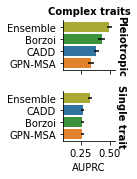

In [31]:
g = sns.FacetGrid(
    data=df.rename(columns={"score": "AUPRC"}),
    col="dataset",
    row="subset",
    margin_titles=True,
    #sharex="col",
    sharex=True,
    sharey=False,
    height=1.3,
    aspect=1.5,
)

def my_boxplot(data, **kwargs):
    data = data.sort_values("AUPRC", ascending=False)
    ax = plt.gca()
    g = sns.barplot(
        data=data,
        y="model",
        x="AUPRC",
        ax=ax,
        palette=palette,
    )
    bar_height = g.patches[0].get_height()
    y_coords = sorted([bar.get_y() + bar_height / 2 for bar in g.patches])
    ax.errorbar(
        x=data["AUPRC"],
        y=y_coords,
        xerr=data["se"],
        fmt='none',
        color="black",
    )

g.map_dataframe(my_boxplot)
g.figure.subplots_adjust(hspace=0)

g.set(
    ylabel="",
    xlim=0.1,
)
g.set_titles(
    col_template="{col_name}", row_template="{row_name}",
    fontweight="bold",
    #size=12,
)
g.tight_layout()
plt.savefig("../../results/plots/performance_pleiotropy.pdf", bbox_inches="tight")

In [2]:
dataset = "complex_traits_matched_9"
V = pd.read_parquet(f"../../results/dataset/{dataset}/test.parquet").query("label")
V

,chrom,pos,ref,alt,pip,trait,label,maf,ld_score,consequence,tss_dist,match_group
8,1,2293397,G,A,0.999932,Height,True,0.370570,32.3020,dELS,65077,dELS_0
17,1,3080038,T,C,0.999895,"MCH,MCV,Plt,RBC",True,0.232720,31.6060,dELS,10826,dELS_1
26,1,3774964,A,G,0.999973,"Hb,HbA1c,MCHC,RBC",True,0.230570,95.3170,dELS,2138,dELS_2
60,1,9181780,G,A,1.000000,"AST,Mono",True,0.074322,35.4720,non_coding_transcript_exon_variant,52677,non_coding_transcript_exon_variant_0
61,1,9295877,G,T,0.993319,DVT,True,0.265060,46.3070,dELS,1348,dELS_3
...,...,...,...,...,...,...,...,...,...,...,...,...
11354,22,45969257,G,A,0.999905,eBMD,True,0.002641,9.5349,dELS,3457,dELS_207
11355,22,45979731,C,T,0.980260,eBMD,True,0.167140,37.7760,dELS,2568,dELS_208
11359,22,46219479,G,A,0.945802,BW,True,0.128710,164.8500,dELS_flank,28805,dELS_flank_108
11372,22,47990921,C,T,0.997536,BMI,True,0.437610,53.5140,intron_variant,498631,intron_variant_124


In [3]:
eqtl = pd.read_parquet("../../results/dataset/complex_traits_matched_9/subset/yes_eqtl_overlap.parquet")
eqtl["eqtl"] = True
eqtl

,chrom,pos,ref,alt,eqtl
0,1,867476,C,T,True
1,1,868052,T,C,True
2,1,868635,A,G,True
3,1,870176,T,A,True
4,1,3690596,G,A,True
...,...,...,...,...,...
1025,22,49967092,T,G,True
1026,22,50190508,G,A,True
1027,22,50343347,G,C,True
1028,22,50368376,T,C,True


In [4]:
disease = pd.read_parquet("../../results/dataset/complex_traits_matched_9/subset/disease.parquet")
disease["disease"] = True
disease

,chrom,pos,ref,alt,disease
0,1,1989803,A,G,True
1,1,2869701,G,T,True
2,1,2878207,G,C,True
3,1,3904770,G,A,True
4,1,4725471,C,T,True
...,...,...,...,...,...
525,22,44812046,G,A,True
526,22,45247338,G,A,True
527,22,48633512,G,C,True
528,22,48705151,G,C,True


In [5]:
V = V.merge(eqtl, on=["chrom", "pos", "ref", "alt"], how="left")
V.eqtl = V.eqtl.fillna(False)
V = V.merge(disease, on=["chrom", "pos", "ref", "alt"], how="left")
V.disease = V.disease.fillna(False)
V

,chrom,pos,ref,alt,pip,trait,label,maf,ld_score,consequence,tss_dist,match_group,eqtl,disease
0,1,2293397,G,A,0.999932,Height,True,0.370570,32.3020,dELS,65077,dELS_0,False,False
1,1,3080038,T,C,0.999895,"MCH,MCV,Plt,RBC",True,0.232720,31.6060,dELS,10826,dELS_1,False,False
2,1,3774964,A,G,0.999973,"Hb,HbA1c,MCHC,RBC",True,0.230570,95.3170,dELS,2138,dELS_2,True,False
3,1,9181780,G,A,1.000000,"AST,Mono",True,0.074322,35.4720,non_coding_transcript_exon_variant,52677,non_coding_transcript_exon_variant_0,True,False
4,1,9295877,G,T,0.993319,DVT,True,0.265060,46.3070,dELS,1348,dELS_3,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,22,45969257,G,A,0.999905,eBMD,True,0.002641,9.5349,dELS,3457,dELS_207,False,False
1136,22,45979731,C,T,0.980260,eBMD,True,0.167140,37.7760,dELS,2568,dELS_208,False,False
1137,22,46219479,G,A,0.945802,BW,True,0.128710,164.8500,dELS_flank,28805,dELS_flank_108,False,False
1138,22,47990921,C,T,0.997536,BMI,True,0.437610,53.5140,intron_variant,498631,intron_variant_124,False,False


In [6]:
V.groupby(["eqtl", "disease"]).size()

eqtl   disease
False  False      990
       True        47
True   False       97
       True         6
dtype: int64

In [7]:
47 / 990

0.047474747474747475

In [8]:
6/ 97

0.061855670103092786

In [9]:
V.groupby("eqtl").tss_dist.mean()

eqtl
False    59123.104147
True     23911.291262
Name: tss_dist, dtype: Float64

In [10]:
other_consequences = [
    "missense_variant",
    "non_coding_transcript_exon_variant",
    "3_prime_UTR_variant",
    "5_prime_UTR_variant",
]
V.loc[~V.consequence.isin(other_consequences), "consequence"] = "non-exonic"

In [11]:
V.groupby("eqtl").consequence.value_counts(normalize=True)

eqtl   consequence                       
False  non-exonic                            0.876567
       non_coding_transcript_exon_variant    0.056895
       3_prime_UTR_variant                   0.040501
       5_prime_UTR_variant                   0.026037
True   non-exonic                            0.660194
       5_prime_UTR_variant                   0.145631
       3_prime_UTR_variant                   0.097087
       non_coding_transcript_exon_variant    0.097087
Name: proportion, dtype: float64

In [12]:
V[V.consequence == "non-exonic"].groupby("eqtl").tss_dist.mean()

eqtl
False    63269.114411
True     29930.308824
Name: tss_dist, dtype: Float64

In [13]:
V[V.consequence == "non-exonic"].groupby("eqtl").tss_dist.median()

eqtl
False    18405.0
True      6712.5
Name: tss_dist, dtype: Float64

In [14]:
df = V.groupby("eqtl").consequence.value_counts(normalize=True).unstack().fillna(0)
df

consequence,3_prime_UTR_variant,5_prime_UTR_variant,non-exonic,non_coding_transcript_exon_variant
eqtl,,,,
False,0.040501,0.026037,0.876567,0.056895
True,0.097087,0.145631,0.660194,0.097087


In [15]:
df2 = V[V.consequence == "non-exonic"]
df2

,chrom,pos,ref,alt,pip,trait,label,maf,ld_score,consequence,tss_dist,match_group,eqtl,disease
0,1,2293397,G,A,0.999932,Height,True,0.370570,32.3020,non-exonic,65077,dELS_0,False,False
1,1,3080038,T,C,0.999895,"MCH,MCV,Plt,RBC",True,0.232720,31.6060,non-exonic,10826,dELS_1,False,False
2,1,3774964,A,G,0.999973,"Hb,HbA1c,MCHC,RBC",True,0.230570,95.3170,non-exonic,2138,dELS_2,True,False
4,1,9295877,G,T,0.993319,DVT,True,0.265060,46.3070,non-exonic,1348,dELS_3,False,True
6,1,10630891,C,T,0.985187,eGFR,True,0.059295,52.9340,non-exonic,14184,dELS_4,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,22,45969257,G,A,0.999905,eBMD,True,0.002641,9.5349,non-exonic,3457,dELS_207,False,False
1136,22,45979731,C,T,0.980260,eBMD,True,0.167140,37.7760,non-exonic,2568,dELS_208,False,False
1137,22,46219479,G,A,0.945802,BW,True,0.128710,164.8500,non-exonic,28805,dELS_flank_108,False,False
1138,22,47990921,C,T,0.997536,BMI,True,0.437610,53.5140,non-exonic,498631,intron_variant_124,False,False


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

<Axes: xlabel='tss_dist', ylabel='Density'>

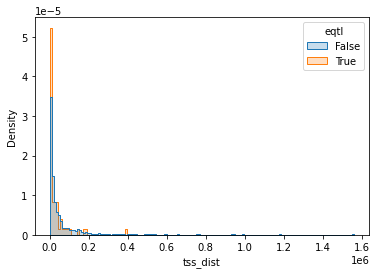

In [16]:
sns.histplot(df2, x="tss_dist", hue="eqtl", element="step", common_norm=False, stat="density")

In [29]:
from scipy.stats import mannwhitneyu
mannwhitneyu(
    df2.query("eqtl").tss_dist.astype(int),
    df2.query("~eqtl").tss_dist.astype(int),
    alternative="less",
)

MannwhitneyuResult(statistic=23309.0, pvalue=0.0003565011929665489)

In [31]:
V["exonic"] = V.consequence != "non-exonic"
df = V.groupby("eqtl").exonic.value_counts()
df

eqtl   exonic
False  False     909
       True      128
True   False      68
       True       35
Name: count, dtype: int64

In [34]:
from scipy.stats import fisher_exact

fisher_exact(df.values.reshape(2, 2), alternative="greater")

SignificanceResult(statistic=3.655215992647059, pvalue=8.189027716001461e-08)

In [36]:
df.values.reshape(2, 2)

array([[909, 128],
       [ 68,  35]])